### Some Installation


In [42]:
# !pip install segmentation-models-pytorch
# !pip install ipywidgets

### Import Libraries

In [43]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import segmentation_models_pytorch as smp

%matplotlib inline

### Set Path

In [44]:
# import os
# from google.colab import drive

# drive.mount('/content/drive')
ROOT_PATH = '/home/yasaisen/Desktop/11_research/11_research_main/lab_06'

In [45]:
# def checkpath(path):
#     if not os.path.exists(path):
#         os.makedirs(path)

In [46]:
# model

Version = '230307_v0.0.6'

root_folder = os.path.abspath(os.path.join(ROOT_PATH, Version))

# model_DIR = os.path.abspath(os.path.join(root_folder, 'model'))
# checkpath(root_folder)

### GroupVit Import

In [47]:
import collections.abc
import math
from dataclasses import dataclass
from typing import Any, Optional, Tuple, Union

import numpy as np
import torch
import torch.utils.checkpoint
from torch import nn

# from ...activations import ACT2FN
from transformers.activations import ACT2FN

# from ...modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
# from ...modeling_utils import PreTrainedModel
from transformers.modeling_utils import PreTrainedModel
# from ...utils import (
#     ModelOutput,
#     add_start_docstrings,
#     add_start_docstrings_to_model_forward,
#     logging,
#     replace_return_docstrings,
# )
from transformers.utils import (
    ModelOutput,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
# from .configuration_groupvit import GroupViTConfig, GroupViTTextConfig, GroupViTVisionConfig
from transformers.models.groupvit.configuration_groupvit import GroupViTConfig, GroupViTTextConfig, GroupViTVisionConfig



In [48]:
logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "nvidia/groupvit-gcc-yfcc"

GROUPVIT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "nvidia/groupvit-gcc-yfcc",
    # See all GroupViT models at https://huggingface.co/models?filter=groupvit
]

In [49]:
# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


In [50]:
# contrastive loss function, adapted from
# https://sachinruk.github.io/blog/pytorch/pytorch%20lightning/loss%20function/gpu/2021/03/07/CLIP.html
def contrastive_loss(logits: torch.Tensor) -> torch.Tensor:
    return nn.functional.cross_entropy(logits, torch.arange(len(logits), device=logits.device))

In [51]:
# Copied from transformers.models.clip.modeling_clip.clip_loss with clip->groupvit
def groupvit_loss(similarity: torch.Tensor) -> torch.Tensor:
    caption_loss = contrastive_loss(similarity)
    image_loss = contrastive_loss(similarity.t())
    return (caption_loss + image_loss) / 2.0

In [52]:
def hard_softmax(logits: torch.Tensor, dim: int):
    y_soft = logits.softmax(dim)
    # Straight through.
    index = y_soft.max(dim, keepdim=True)[1]
    y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
    ret = y_hard - y_soft.detach() + y_soft

    return ret

In [53]:
def gumbel_softmax(logits: torch.Tensor, tau: float = 1, hard: bool = False, dim: int = -1) -> torch.Tensor:
    # more stable https://github.com/pytorch/pytorch/issues/41663
    gumbel_dist = torch.distributions.gumbel.Gumbel(
        torch.tensor(0.0, device=logits.device, dtype=logits.dtype),
        torch.tensor(1.0, device=logits.device, dtype=logits.dtype),
    )
    gumbels = gumbel_dist.sample(logits.shape)

    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [54]:
def resize_attention_map(attentions, height, width, align_corners=False):
    """
    Args:
        attentions (`torch.Tensor`): attention map of shape [batch_size, groups, feat_height*feat_width]
        height (`int`): height of the output attention map
        width (`int`): width of the output attention map
        align_corners (`bool`, *optional*): the `align_corner` argument for `nn.functional.interpolate`.

    Returns:
        `torch.Tensor`: resized attention map of shape [batch_size, groups, height, width]
    """

    scale = (height * width // attentions.shape[2]) ** 0.5
    if height > width:
        feat_width = int(np.round(width / scale))
        feat_height = attentions.shape[2] // feat_width
    else:
        feat_height = int(np.round(height / scale))
        feat_width = attentions.shape[2] // feat_height

    batch_size = attentions.shape[0]
    groups = attentions.shape[1]  # number of group token
    # [batch_size, groups, height*width, groups] -> [batch_size, groups, height, width]
    attentions = attentions.reshape(batch_size, groups, feat_height, feat_width)
    attentions = nn.functional.interpolate(
        attentions, size=(height, width), mode="bilinear", align_corners=align_corners
    )
    return attentions

In [55]:
def get_grouping_from_attentions(attentions, hw_shape):
    """
    Args:
        attentions (`tuple(torch.FloatTensor)`: tuple of attention maps returned by `GroupViTVisionTransformer`
        hw_shape (`tuple(int)`): height and width of the output attention map
    Returns:
        `torch.Tensor`: the attention map of shape [batch_size, groups, height, width]
    """

    attn_maps = []
    with torch.no_grad():
        prev_attn_masks = None
        for attn_masks in attentions:
            # [batch_size, num_groups, height x width] -> [batch_size, height x width, num_groups]
            attn_masks = attn_masks.permute(0, 2, 1).contiguous()
            if prev_attn_masks is None:
                prev_attn_masks = attn_masks
            else:
                prev_attn_masks = prev_attn_masks @ attn_masks
            # [batch_size, heightxwidth, num_groups] -> [batch_size, num_groups, heightxwidth] -> [batch_size, num_groups, height, width]
            cur_attn_map = resize_attention_map(prev_attn_masks.permute(0, 2, 1).contiguous(), *hw_shape)
            attn_maps.append(cur_attn_map)

    # [batch_size, num_groups, height, width]
    final_grouping = attn_maps[-1]

    return final_grouping

In [56]:
class GroupViTCrossAttentionLayer(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.attn = GroupViTAttention(config)
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp = GroupViTMLP(config)
        self.norm_post = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, query, key):
        x = query
        x = x + self.attn(query, encoder_hidden_states=key)[0]
        x = x + self.mlp(self.norm2(x))
        x = self.norm_post(x)
        return x

In [57]:
class GroupViTAssignAttention(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.scale = config.hidden_size**-0.5

        self.q_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.k_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.v_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.assign_eps = config.assign_eps

    def get_attn(self, attn, gumbel=True, hard=True):
        if gumbel and self.training:
            attn = gumbel_softmax(attn, dim=-2, hard=hard)
        else:
            if hard:
                attn = hard_softmax(attn, dim=-2)
            else:
                attn = nn.functional.softmax(attn, dim=-2)

        return attn

    def forward(self, query, key):
        value = key
        # [batch_size, query_length, channels]
        query = self.q_proj(query)

        # [batch_size, key_length, channels]
        key = self.k_proj(key)

        # [batch_size, key_length, channels]
        value = self.v_proj(value)

        # [batch_size, query_length, key_length]
        raw_attn = (query @ key.transpose(-2, -1)) * self.scale

        attn = self.get_attn(raw_attn)
        soft_attn = self.get_attn(raw_attn, gumbel=False, hard=False)

        attn = attn / (attn.sum(dim=-1, keepdim=True) + self.assign_eps)

        out = attn @ value

        out = self.proj(out)

        return out, soft_attn

In [58]:
class GroupViTTokenAssign(nn.Module):
    def __init__(self, config: GroupViTVisionConfig, num_group_token, num_output_group):
        super().__init__()
        self.num_output_group = num_output_group
        # norm on group_tokens
        self.norm_tokens = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        assign_mlp_ratio = (
            config.assign_mlp_ratio
            if isinstance(config.assign_mlp_ratio, collections.abc.Iterable)
            else (config.assign_mlp_ratio, config.assign_mlp_ratio)
        )
        tokens_dim, channels_dim = [int(x * config.hidden_size) for x in assign_mlp_ratio]
        self.mlp_inter = GroupViTMixerMLP(config, num_group_token, tokens_dim, num_output_group)
        self.norm_post_tokens = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # norm on x
        self.norm_x = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.pre_assign_attn = GroupViTCrossAttentionLayer(config)

        self.assign = GroupViTAssignAttention(config)
        self.norm_new_x = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp_channels = GroupViTMLP(config, config.hidden_size, channels_dim, config.hidden_size)

    def project_group_token(self, group_tokens):
        """
        Args:
            group_tokens (torch.Tensor): group tokens, [batch_size, num_group_tokens, channels]

        Returns:
            projected_group_tokens (torch.Tensor): [batch_size, num_output_groups, channels]
        """
        # [B, num_output_groups, C] <- [B, num_group_tokens, C]
        projected_group_tokens = self.mlp_inter(group_tokens)
        projected_group_tokens = self.norm_post_tokens(projected_group_tokens)
        return projected_group_tokens

    def forward(self, image_tokens, group_tokens):
        """
        Args:
            image_tokens (`torch.Tensor`): image tokens, of shape [batch_size, input_length, channels]
            group_tokens (`torch.Tensor`): group tokens, [batch_size, num_group_tokens, channels]
        """

        group_tokens = self.norm_tokens(group_tokens)
        image_tokens = self.norm_x(image_tokens)
        # [batch_size, num_output_groups, channels]
        projected_group_tokens = self.project_group_token(group_tokens)
        projected_group_tokens = self.pre_assign_attn(projected_group_tokens, image_tokens)
        new_image_tokens, attention = self.assign(projected_group_tokens, image_tokens)
        new_image_tokens += projected_group_tokens

        new_image_tokens = new_image_tokens + self.mlp_channels(self.norm_new_x(new_image_tokens))

        return new_image_tokens, attention


In [59]:
@dataclass
class GroupViTModelOutput(ModelOutput):
    """
    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `return_loss` is `True`):
            Contrastive loss for image-text similarity.
        logits_per_image (`torch.FloatTensor` of shape `(image_batch_size, text_batch_size)`):
            The scaled dot product scores between `image_embeds` and `text_embeds`. This represents the image-text
            similarity scores.
        logits_per_text (`torch.FloatTensor` of shape `(text_batch_size, image_batch_size)`):
            The scaled dot product scores between `text_embeds` and `image_embeds`. This represents the text-image
            similarity scores.
        segmentation_logits (`torch.FloatTensor` of shape `(batch_size, config.num_labels, logits_height, logits_width)`):
            Classification scores for each pixel.

            <Tip warning={true}>

            The logits returned do not necessarily have the same size as the `pixel_values` passed as inputs. This is
            to avoid doing two interpolations and lose some quality when a user needs to resize the logits to the
            original image size as post-processing. You should always check your logits shape and resize as needed.

            </Tip>

        text_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim`):
            The text embeddings obtained by applying the projection layer to the pooled output of
            [`GroupViTTextModel`].
        image_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim`):
            The image embeddings obtained by applying the projection layer to the pooled output of
            [`GroupViTVisionModel`].
        text_model_output (`BaseModelOutputWithPooling`):
            The output of the [`GroupViTTextModel`].
        vision_model_output (`BaseModelOutputWithPooling`):
            The output of the [`GroupViTVisionModel`].
    """

    loss: Optional[torch.FloatTensor] = None
    logits_per_image: torch.FloatTensor = None
    logits_per_text: torch.FloatTensor = None
    segmentation_logits: torch.FloatTensor = None
    text_embeds: torch.FloatTensor = None
    image_embeds: torch.FloatTensor = None
    text_model_output: BaseModelOutputWithPooling = None
    vision_model_output: BaseModelOutputWithPooling = None

    def to_tuple(self) -> Tuple[Any]:
        return tuple(
            self[k] if k not in ["text_model_output", "vision_model_output"] else getattr(self, k).to_tuple()
            for k in self.keys()
        )

In [60]:
class GroupViTPatchEmbeddings(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        image_size: int = 224,
        patch_size: Union[int, Tuple[int, int]] = 16,
        num_channels: int = 3,
        embed_dim: int = 768,
    ):
        super().__init__()
        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.projection = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        if not interpolate_pos_encoding:
            if height != self.image_size[0] or width != self.image_size[1]:
                raise ValueError(
                    f"Input image size ({height}*{width}) doesn't match model"
                    f" ({self.image_size[0]}*{self.image_size[1]})."
                )
        x = self.projection(pixel_values).flatten(2).transpose(1, 2)
        return x

In [61]:
class GroupViTVisionEmbeddings(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()

        self.patch_embeddings = GroupViTPatchEmbeddings(
            image_size=config.image_size,
            patch_size=config.patch_size,
            num_channels=config.num_channels,
            embed_dim=config.hidden_size,
        )
        num_patches = self.patch_embeddings.num_patches
        self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches, config.hidden_size))
        self.dropout = nn.Dropout(config.dropout)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.config = config

    def interpolate_pos_encoding(self, embeddings: torch.Tensor, height: int, width: int) -> torch.Tensor:
        """
        This method allows to interpolate the pre-trained position encodings, to be able to use the model on higher
        resolution images.

        Source:
        https://github.com/facebookresearch/dino/blob/de9ee3df6cf39fac952ab558447af1fa1365362a/vision_transformer.py#L174
        """

        npatch = embeddings.shape[1]
        if npatch == self.position_embeddings.shape[1] and height == width:
            return self.position_embeddings
        patch_pos_embed = self.position_embeddings
        num_original_pos_embed = patch_pos_embed.shape[1]
        dim = embeddings.shape[-1]
        feat_height = height // self.config.patch_size
        feat_width = width // self.config.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        feat_height, feat_width = feat_height + 0.1, feat_width + 0.1
        original_height = original_width = math.sqrt(num_original_pos_embed)
        reshaped_patch_pos_embed = patch_pos_embed.reshape(1, int(original_height), int(original_width), dim).permute(
            0, 3, 1, 2
        )
        scale_factor = (feat_height / original_height, feat_width / original_width)
        patch_pos_embed = nn.functional.interpolate(
            reshaped_patch_pos_embed,
            scale_factor=scale_factor,
            mode="bicubic",
            align_corners=False,
        )
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return patch_pos_embed

    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        embeddings = self.patch_embeddings(pixel_values, interpolate_pos_encoding=interpolate_pos_encoding)

        embeddings = self.layernorm(embeddings)

        batch_size, seq_len, _ = embeddings.size()

        # add positional encoding to each token
        if interpolate_pos_encoding:
            embeddings = embeddings + self.interpolate_pos_encoding(embeddings, height, width)
        else:
            embeddings = embeddings + self.position_embeddings

        embeddings = self.dropout(embeddings)

        return embeddings

In [62]:
# Copied from transformers.models.clip.modeling_clip.CLIPTextEmbeddings with CLIP->GroupViT
class GroupViTTextEmbeddings(nn.Module):
    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        embed_dim = config.hidden_size

        self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
    ) -> torch.Tensor:
        seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        if inputs_embeds is None:
            inputs_embeds = self.token_embedding(input_ids)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings

In [63]:
class GroupViTStage(nn.Module):
    """This corresponds to the `GroupingLayer` class in the GroupViT implementation."""

    def __init__(
        self,
        config: GroupViTVisionConfig,
        depth: int,
        num_prev_group_token: int,
        num_group_token: int,
        num_output_group: int,
    ):
        super().__init__()
        self.depth = depth
        self.num_group_token = num_group_token
        if num_group_token > 0:
            self.group_token = nn.Parameter(torch.zeros(1, num_group_token, config.hidden_size))
        else:
            self.group_token = None
        self.gradient_checkpointing = False
        self.layers = nn.ModuleList([GroupViTEncoderLayer(config) for _ in range(depth)])

        if num_group_token > 0:
            self.downsample = GroupViTTokenAssign(
                config=config,
                num_group_token=num_group_token,
                num_output_group=num_output_group,
            )
        else:
            self.downsample = None

        if num_prev_group_token > 0 and num_group_token > 0:
            self.group_projector = nn.Sequential(
                nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps),
                GroupViTMixerMLP(config, num_prev_group_token, config.hidden_size // 2, num_group_token),
            )
        else:
            self.group_projector = None

    @property
    def with_group_token(self):
        return self.group_token is not None

    def split_x(self, x):
        if self.with_group_token:
            return x[:, : -self.num_group_token], x[:, -self.num_group_token :]
        else:
            return x, None

    def concat_x(self, x: torch.Tensor, group_token: Optional[torch.Tensor] = None) -> torch.Tensor:
        if group_token is None:
            return x
        return torch.cat([x, group_token], dim=1)

    def forward(
        self,
        hidden_states: torch.Tensor,
        prev_group_token: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
                `(config.encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the grouping tensors of Grouping block.
        """
        if self.with_group_token:
            group_token = self.group_token.expand(hidden_states.size(0), -1, -1)
            if self.group_projector is not None:
                group_token = group_token + self.group_projector(prev_group_token)
        else:
            group_token = None

        x = hidden_states

        cat_x = self.concat_x(x, group_token)
        for layer in self.layers:
            layer_out = layer(cat_x, attention_mask=None, causal_attention_mask=None)
            cat_x = layer_out[0]

        x, group_token = self.split_x(cat_x)

        attention = None
        if self.downsample is not None:
            x, attention = self.downsample(x, group_token)

        outputs = (x, group_token)
        if output_attentions:
            outputs = outputs + (attention,)

        return outputs

In [64]:
class GroupViTMLP(nn.Module):
    def __init__(
        self,
        config: GroupViTVisionConfig,
        hidden_size: Optional[int] = None,
        intermediate_size: Optional[int] = None,
        output_size: Optional[int] = None,
    ):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        hidden_size = hidden_size if hidden_size is not None else config.hidden_size
        intermediate_size = intermediate_size if intermediate_size is not None else config.intermediate_size
        output_size = output_size if output_size is not None else hidden_size
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states

In [65]:
class GroupViTMixerMLP(GroupViTMLP):
    def forward(self, x):
        x = super().forward(x.transpose(1, 2))
        return x.transpose(1, 2)

In [66]:
class GroupViTAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {self.num_heads})."
            )
        self.scale = self.head_dim**-0.5
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        bsz, tgt_len, embed_dim = hidden_states.size()
        is_cross_attention = encoder_hidden_states is not None

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scale
        if is_cross_attention:
            key_states = self._shape(self.k_proj(encoder_hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(encoder_hidden_states), -1, bsz)
        else:
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        # apply the causal_attention_mask first
        if causal_attention_mask is not None:
            if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is"
                    f" {causal_attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + causal_attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if output_attentions:
            # this operation is a bit akward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped


In [67]:
# Copied from transformers.models.clip.modeling_clip.CLIPEncoderLayer with CLIP->GroupViT
class GroupViTEncoderLayer(nn.Module):
    def __init__(self, config: GroupViTConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = GroupViTAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = GroupViTMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        causal_attention_mask: torch.Tensor,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
                `(config.encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs

In [68]:
class GroupViTPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = GroupViTConfig
    base_model_prefix = "groupvit"
    supports_gradient_checkpointing = True
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights"""

        init_range = self.config.initializer_range
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=init_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

        factor = self.config.initializer_factor
        if isinstance(module, GroupViTTextEmbeddings):
            module.token_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
            module.position_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
        elif isinstance(module, GroupViTAttention):
            factor = self.config.initializer_factor
            in_proj_std = (module.embed_dim**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            out_proj_std = (module.embed_dim**-0.5) * factor
            nn.init.normal_(module.q_proj.weight, std=in_proj_std)
            nn.init.normal_(module.k_proj.weight, std=in_proj_std)
            nn.init.normal_(module.v_proj.weight, std=in_proj_std)
            nn.init.normal_(module.out_proj.weight, std=out_proj_std)
        elif isinstance(module, GroupViTMLP):
            factor = self.config.initializer_factor
            in_proj_std = (
                (module.config.hidden_size**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            )
            fc_std = (2 * module.config.hidden_size) ** -0.5 * factor
            nn.init.normal_(module.fc1.weight, std=fc_std)
            nn.init.normal_(module.fc2.weight, std=in_proj_std)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, (GroupViTTextEncoder, GroupViTVisionEncoder)):
            module.gradient_checkpointing = value

In [69]:
GROUPVIT_START_DOCSTRING = r"""
    This model is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass. Use it
    as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and
    behavior.

    Parameters:
        config ([`GroupViTConfig`]): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

GROUPVIT_TEXT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`CLIPTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

GROUPVIT_VISION_INPUTS_DOCSTRING = r"""
    Args:
        pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            Pixel values. Padding will be ignored by default should you provide it. Pixel values can be obtained using
            [`AutoImageProcessor`]. See [`CLIPImageProcessor.__call__`] for details.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

GROUPVIT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`CLIPTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See
            [`CLIPImageProcessor.__call__`] for details.
        return_loss (`bool`, *optional*):
            Whether or not to return the contrastive loss.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

In [70]:
class GroupViTVisionEncoder(nn.Module):
    def __init__(self, config: GroupViTVisionConfig) -> None:
        super().__init__()
        self.config = config
        self.stages = nn.ModuleList(
            [
                GroupViTStage(
                    config=config,
                    depth=config.depths[i],
                    num_group_token=config.num_group_tokens[i],
                    num_output_group=config.num_output_groups[i],
                    num_prev_group_token=config.num_output_groups[i - 1] if i > 0 else 0,
                )
                for i in range(len(config.depths))
            ]
        )
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, BaseModelOutput]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        all_hidden_states = () if output_hidden_states else None
        all_groupings = () if output_attentions else None

        group_tokens = None

        for i, stage in enumerate(self.stages):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = stage(hidden_states, group_tokens, output_attentions)

            hidden_states = layer_outputs[0]
            group_tokens = layer_outputs[1]

            if output_attentions and layer_outputs[2] is not None:
                all_groupings = all_groupings + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_groupings] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=all_hidden_states, attentions=all_groupings
        )

In [71]:
class GroupViTTextEncoder(nn.Module):
    """
    Transformer encoder consisting of `config.num_hidden_layers` self-attention layers. Each layer is a
    [`GroupViTEncoderLayer`].

    Args:
        config: GroupViTTextConfig
    """

    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([GroupViTEncoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        inputs_embeds,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutput]:
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            causal_attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Causal mask for the text model. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        hidden_states = inputs_embeds
        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(encoder_layer),
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                )
            else:
                layer_outputs = encoder_layer(
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                    output_attentions=output_attentions,
                )

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )

In [72]:
# Copied from transformers.models.clip.modeling_clip.CLIPTextTransformer with CLIPText->GroupViTText, CLIPEncoder->GroupViTTextEncoder, CLIP_TEXT->GROUPVIT_TEXT
class GroupViTTextTransformer(nn.Module):
    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = GroupViTTextEmbeddings(config)
        self.encoder = GroupViTTextEncoder(config)
        self.final_layer_norm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is None:
            raise ValueError("You have to specify input_ids")

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])

        hidden_states = self.embeddings(input_ids=input_ids, position_ids=position_ids)

        bsz, seq_len = input_shape
        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = self._build_causal_attention_mask(bsz, seq_len, hidden_states.dtype).to(
            hidden_states.device
        )
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)

        encoder_outputs = self.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = self.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

    def _build_causal_attention_mask(self, bsz, seq_len, dtype):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
        mask.fill_(torch.tensor(torch.finfo(dtype).min))
        mask.triu_(1)  # zero out the lower diagonal
        mask = mask.unsqueeze(1)  # expand mask
        return mask

In [73]:
class GroupViTTextModel(GroupViTPreTrainedModel):
    config_class = GroupViTTextConfig

    def __init__(self, config: GroupViTTextConfig):
        super().__init__(config)
        self.text_model = GroupViTTextTransformer(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> nn.Module:
        return self.text_model.embeddings.token_embedding

    def set_input_embeddings(self, value):
        self.text_model.embeddings.token_embedding = value

    @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from transformers import CLIPTokenizer, GroupViTTextModel

        >>> tokenizer = CLIPTokenizer.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> model = GroupViTTextModel.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled (EOS token) states
        ```"""
        return self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

In [74]:
class GroupViTVisionTransformer(nn.Module):########################
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = GroupViTVisionEmbeddings(config)
        self.encoder = GroupViTVisionEncoder(config)
        self.layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTVisionConfig)
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        hidden_states = self.embeddings(pixel_values)

        encoder_outputs = self.encoder(
            hidden_states=hidden_states,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]

        # normalize the last hidden state
        last_hidden_state = self.layernorm(last_hidden_state)
        pooled_output = last_hidden_state.mean(dim=1)

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [75]:
class GroupViTVisionModel(GroupViTPreTrainedModel):
    config_class = GroupViTVisionConfig
    main_input_name = "pixel_values"

    def __init__(self, config: GroupViTVisionConfig):
        super().__init__(config)
        self.vision_model = GroupViTVisionTransformer(config)

        self.projection_dim = 128
        self.projection_intermediate_dim = 4096
        self.vision_embed_dim = config.hidden_size

        self.visual_projection = nn.Sequential(
            nn.Linear(self.vision_embed_dim, self.projection_intermediate_dim, bias=True),
            nn.BatchNorm1d(self.projection_intermediate_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        )

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> GroupViTPatchEmbeddings:
        return self.vision_model.embeddings.patch_embeddings

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTVisionConfig)
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTVisionModel

        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> model = GroupViTVisionModel.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(images=image, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled CLS states
        ```"""

        # print(type(pixel_values), type(output_attentions), type(output_hidden_states), type(return_dict))
        # print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)
        # print('pixel_values=', pixel_values.shape)
        output_attentions = True
        output_hidden_states = False
        return_dict = True
        # print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)
        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        # print(vision_outputs)

        attentions = vision_outputs[2]
            
        # [batch_size_image, num_group, height, width]
        grouping = get_grouping_from_attentions(attentions, pixel_values.shape[2:])
        seg_logits = grouping

        pooled_output = vision_outputs[1]  # pooled_output
        image_features = self.visual_projection(pooled_output)

        # print(image_features.shape)
        return vision_outputs, seg_logits, image_features

In [76]:
@add_start_docstrings(GROUPVIT_START_DOCSTRING)
class GroupViTModel(GroupViTPreTrainedModel):
    config_class = GroupViTConfig

    def __init__(self, config: GroupViTConfig):
        super().__init__(config)

        # if not isinstance(config.text_config, GroupViTTextConfig):
        #     raise ValueError(
        #         "config.text_config is expected to be of type GroupViTTextConfig but is of type"
        #         f" {type(config.text_config)}."
        #     )

        if not isinstance(config.vision_config, GroupViTVisionConfig):
            raise ValueError(
                "config.vision_config is expected to be of type GroupViTVisionConfig but is of type"
                f" {type(config.vision_config)}."
            )

        # text_config = config.text_config
        vision_config = config.vision_config

        self.projection_dim = config.projection_dim
        self.projection_intermediate_dim = config.projection_intermediate_dim
        # self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size
        print('hidden_size', vision_config.hidden_size)

        # self.text_model = GroupViTTextTransformer(text_config)
        self.vision_model = GroupViTVisionTransformer(vision_config)

        self.visual_projection = nn.Sequential(
            nn.Linear(self.vision_embed_dim, self.projection_intermediate_dim, bias=True),
            nn.BatchNorm1d(self.projection_intermediate_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        )
        # self.text_projection = nn.Sequential(
        #     nn.Linear(self.text_embed_dim, self.projection_intermediate_dim, bias=True),
        #     nn.BatchNorm1d(self.projection_intermediate_dim),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        # )
        self.logit_scale = nn.Parameter(torch.ones([]) * self.config.logit_scale_init_value)

        # Initialize weights and apply final processing
        self.post_init()

    # @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    # def get_text_features(
    #     self,
    #     input_ids: Optional[torch.Tensor] = None,
    #     attention_mask: Optional[torch.Tensor] = None,
    #     position_ids: Optional[torch.Tensor] = None,
    #     output_attentions: Optional[bool] = None,
    #     output_hidden_states: Optional[bool] = None,
    #     return_dict: Optional[bool] = None,
    # ) -> torch.FloatTensor:
    #     r"""
    #     Returns:
    #         text_features (`torch.FloatTensor` of shape `(batch_size, output_dim`): The text embeddings obtained by
    #         applying the projection layer to the pooled output of [`GroupViTTextModel`].

    #     Examples:

    #     ```python
    #     >>> from transformers import CLIPTokenizer, GroupViTModel

    #     >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
    #     >>> tokenizer = CLIPTokenizer.from_pretrained("nvidia/groupvit-gcc-yfcc")

    #     >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
    #     >>> text_features = model.get_text_features(**inputs)
    #     ```"""
    #     # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
    #     output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    #     output_hidden_states = (
    #         output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    #     )
    #     return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    #     text_outputs = self.text_model(
    #         input_ids=input_ids,
    #         attention_mask=attention_mask,
    #         position_ids=position_ids,
    #         output_attentions=output_attentions,
    #         output_hidden_states=output_hidden_states,
    #         return_dict=return_dict,
    #     )

    #     pooled_output = text_outputs[1]
    #     text_features = self.text_projection(pooled_output)

    #     return text_features

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    def get_image_features(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> torch.FloatTensor:
        r"""
        Returns:
            image_features (`torch.FloatTensor` of shape `(batch_size, output_dim`): The image embeddings obtained by
            applying the projection layer to the pooled output of [`GroupViTVisionModel`].

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTModel

        >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(images=image, return_tensors="pt")

        >>> image_features = model.get_image_features(**inputs)
        ```"""
        # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = vision_outputs[1]  # pooled_output
        print('01 ', pooled_output.shape)

        image_features = self.visual_projection(pooled_output)
        print('02 ', image_features.shape)

        return image_features

    @add_start_docstrings_to_model_forward(GROUPVIT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=GroupViTModelOutput, config_class=GroupViTConfig)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_segmentation: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, GroupViTModelOutput]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTModel

        >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(
        ...     text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
        ... )

        >>> outputs = model(**inputs)
        >>> logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        >>> probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        ```"""
        # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_segmentation = (
            output_segmentation if output_segmentation is not None else self.config.output_segmentation
        )
        if output_segmentation:
            output_attentions = True
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # print(type(pixel_values), type(output_attentions), type(output_hidden_states), type(return_dict))
        print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        # print(vision_outputs)

        # text_outputs = self.text_model(
        #     input_ids=input_ids,
        #     attention_mask=attention_mask,
        #     position_ids=position_ids,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=return_dict,
        # )

        image_embeds = vision_outputs[1]
        image_embeds = self.visual_projection(image_embeds)

        # text_embeds = text_outputs[1]
        # text_embeds = self.text_projection(text_embeds)

        # normalized features
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        # text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        # logit_scale = self.logit_scale.exp()
        # logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
        # logits_per_image = logits_per_text.t()

        seg_logits = None
        if output_segmentation:
            # grouped features
            # [batch_size_image, num_group, hidden_size]
            image_group_embeds = vision_outputs[0]
            print('image_group_embeds_01', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([1, 8, 384]) <class 'torch.Tensor'>

            # [batch_size_image*num_group, hidden_size]
            image_group_embeds = self.visual_projection(image_group_embeds.reshape(-1, image_group_embeds.shape[-1]))
            print('image_group_embeds_02', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([8, 256]) <class 'torch.Tensor'>

            if output_hidden_states:
                attentions = vision_outputs[3]
                print('attentions_01', attentions.shape, type(attentions)) # *

            else:
                attentions = vision_outputs[2]
                print('attentions_02', attentions[0].shape, type(attentions[0]), attentions[1].shape, type(attentions[1])) # torch.Size([1, 64, 196]) torch.Size([1, 8, 64]) <class 'torch.Tensor'>
                
            # [batch_size_image, num_group, height, width]
            grouping = get_grouping_from_attentions(attentions, pixel_values.shape[2:])
            print(pixel_values.shape)
            print(pixel_values.shape[2:])
            print('grouping_01', grouping.shape, type(grouping)) # torch.Size([1, 8, 224, 224]) <class 'torch.Tensor'>
            seg_logits = grouping

            # # normalized features
            # image_group_embeds = image_group_embeds / image_group_embeds.norm(dim=-1, keepdim=True)
            # print('image_group_embeds_03', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([8, 256]) <class 'torch.Tensor'>

            # # [batch_size_image x num_group, batch_size_text]
            # logits_per_image_group = torch.matmul(image_group_embeds, text_embeds.t()) * logit_scale
            # print('logits_per_image_group_01', logits_per_image_group.shape, type(logits_per_image_group)) # torch.Size([8, 3]) <class 'torch.Tensor'>

            # # [batch_size_image, batch_size_text, num_group]
            # logits_per_image_group = logits_per_image_group.reshape(
            #     image_embeds.shape[0], -1, text_embeds.shape[0]
            # ).permute(0, 2, 1)
            # print('logits_per_image_group_02', logits_per_image_group.shape, type(logits_per_image_group)) # torch.Size([1, 3, 8]) <class 'torch.Tensor'>


            # # [batch_size_image, batch_size_text, height x width]
            # flatten_grouping = grouping.reshape(grouping.shape[0], grouping.shape[1], -1)
            # print('flatten_grouping_01', flatten_grouping.shape, type(flatten_grouping)) # torch.Size([1, 8, 50176]) <class 'torch.Tensor'>


            # # [batch_size_image, batch_size_text, height, width]
            # seg_logits = torch.matmul(logits_per_image_group, flatten_grouping) * logit_scale
            # print('seg_logits_01', seg_logits.shape, type(seg_logits)) # torch.Size([1, 3, 50176]) <class 'torch.Tensor'>

            # seg_logits = seg_logits.reshape(
            #     seg_logits.shape[0], seg_logits.shape[1], grouping.shape[2], grouping.shape[3]
            # )
            # print('seg_logits_02', seg_logits.shape, type(seg_logits)) # torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>

        loss = None
        if return_loss:
            loss = groupvit_loss(logits_per_text)

        if not return_dict:
            if seg_logits is not None:
                output = (
                    logits_per_image,
                    logits_per_text,
                    seg_logits,
                    text_embeds,
                    image_embeds,
                    text_outputs,
                    vision_outputs,
                )
            else:
                output = (logits_per_image, logits_per_text, text_embeds, image_embeds, text_outputs, vision_outputs)
            return ((loss,) + output) if loss is not None else output

        return GroupViTModelOutput(
            loss=loss,
            # logits_per_image=logits_per_image,
            # logits_per_text=logits_per_text,
            segmentation_logits=seg_logits,
            # text_embeds=text_embeds,
            image_embeds=image_embeds,
            # text_model_output=text_outputs,
            vision_model_output=vision_outputs,
        )

### Set Arguments

In [77]:
class Config:
    
    data_dir = os.path.join(ROOT_PATH, 'fine-tune_set', 'siim-acr-pneumothorax')
    
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 16
    test_batch = 16
    
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    seed = 1
    learning_rate = 0.01
    epochs = 30
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(device)

cuda


### Dataset Import

#### get from path

In [78]:
 # non-segmap_data

images, masks = [], []

i = 0

for get_folder in os.listdir(Config.data_dir):
    if get_folder == 'png_images':
        for get_file in os.listdir(os.path.join(Config.data_dir, 'png_images')):
            if get_file in os.listdir(os.path.join(Config.data_dir, 'png_masks')):
                images += [os.path.join(Config.data_dir, 'png_images', get_file)]
                masks += [os.path.join(Config.data_dir, 'png_masks', get_file)]
                i = i+1

PathDF = pd.DataFrame({'images': images, 'masks': masks})
print(i)
PathDF.head()

12047


,images,masks
0,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
1,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
2,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
3,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...
4,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...


In [79]:
for i in PathDF.index:
    PathDF.loc[i, "pneumothorax"] = 1 if np.max(cv2.imread(PathDF.loc[i,"masks"])) > 0 else 0
PathDF.head()

,images,masks,pneumothorax
0,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...,1.0
1,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...,1.0
2,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...,0.0
3,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...,0.0
4,/home/yasaisen/Desktop/11_research/11_research...,/home/yasaisen/Desktop/11_research/11_research...,0.0


In [80]:
PathDF['pneumothorax'].value_counts()

0.0    9378
1.0    2669
Name: pneumothorax, dtype: int64

#### visualize data

In [81]:
def plot_example(idx):
    image_path = PathDF['images'].iloc[idx]
    mask_path = PathDF['masks'].iloc[idx]
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    print(np.max(np.asarray(mask)))
    
    fig, ax = plt.subplots(1, 3, figsize=(8,4))
    ax[0].imshow(np.array(image).astype(np.uint8))
    ax[0].set_title("Image")
    ax[1].imshow(np.array(mask).astype(np.uint8))
    ax[1].set_title("Mask")
    img = np.array(image) * 0.3 + np.array(mask) * 0.7
    img = img.astype(np.uint8)
    ax[2].imshow(img)
    ax[2].set_title('')
    plt.show()

255


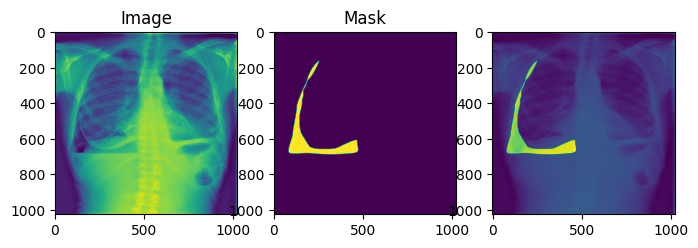

255


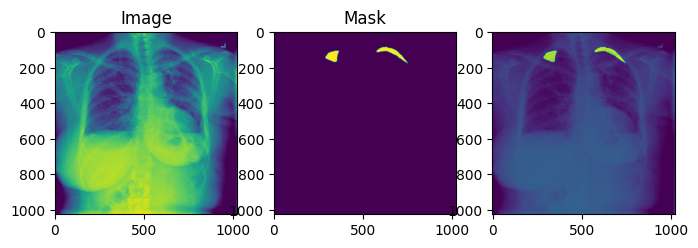

255


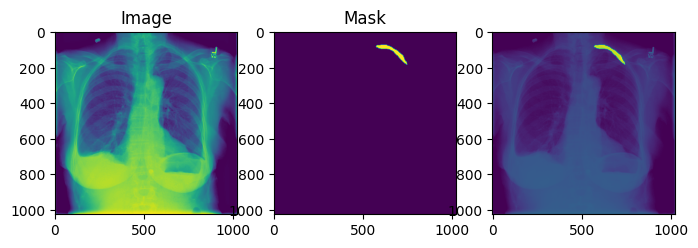

0


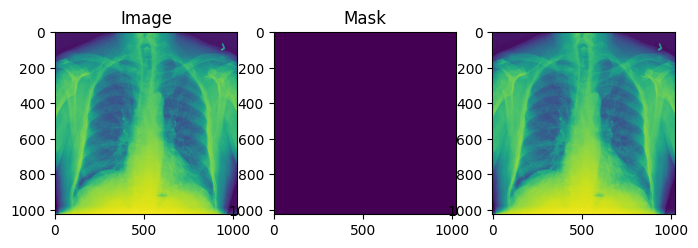

In [82]:
plot_example(0)
plot_example(50)
plot_example(88)
plot_example(190)

#### split sets

In [83]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction / train2rest

train_df, rest = train_test_split(PathDF, random_state=Config.seed, test_size = train2rest)
test_df, valid_df = train_test_split(rest, random_state=Config.seed, test_size = test2valid)

print('Train:', train_df.shape[0], train_df['pneumothorax'].value_counts()[1])
print('Valid:', valid_df.shape[0], valid_df['pneumothorax'].value_counts()[1])
print('Test:', test_df.shape[0], test_df['pneumothorax'].value_counts()[1])

Train: 9035 2006
Valid: 1808 380
Test: 1204 283


#### transformations

In [84]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor()
            ])

#### set dataset & loader

In [85]:
np.asarray(Image.open(test_df.iloc[2]['masks']).convert('RGB')).shape

(1024, 1024, 3)

In [86]:
class CXR_Dataset(Dataset):
    def __init__(self, path_df, transform):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.path_df.iloc[idx]['images']
        mask_path = self.path_df.iloc[idx]['masks']
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask#sample = (image, mask)

In [87]:
train_data = CXR_Dataset(train_df, transform)
valid_data = CXR_Dataset(valid_df, transform)
test_data  = CXR_Dataset(test_df, transform)

train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data , batch_size=Config.test_batch , shuffle=False, num_workers=0)

### Define Model

In [88]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.up_1 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2), nn.ReLU())
    self.up_2 = nn.Sequential(nn.ConvTranspose2d( 64, 32, kernel_size=3, stride=2), nn.ReLU())
    self.up_3 = nn.Sequential(nn.ConvTranspose2d( 32, 16, kernel_size=2, stride=2), nn.ReLU())
    self.up_4 = nn.Sequential(nn.ConvTranspose2d( 16,  8, kernel_size=2, stride=2), nn.ReLU())
    self.up_5 = nn.Sequential(nn.ConvTranspose2d(  8,  4, kernel_size=2, stride=2), nn.ReLU())
    self.up_6 = nn.Sequential(nn.ConvTranspose2d(  4,  2, kernel_size=2, stride=2), nn.ReLU())
    self.up_7 = nn.Sequential(nn.ConvTranspose2d(  2,  1, kernel_size=2, stride=2), nn.Sigmoid())

  def forward(self, x):              # ([1, 128])
    x = x.view(x.size(0), 128, 1, 1) # ([128,   1,   1])
    x = self.up_1(x)                 # ([ 64,   3,   3])
    x = self.up_2(x)                 # ([ 32,   7,   7])
    x = self.up_3(x)                 # ([ 16,  14,  14])
    x = self.up_4(x)                 # ([  8,  28,  28])
    x = self.up_5(x)                 # ([  4,  56,  56])
    x = self.up_6(x)                 # ([  2, 112, 112])
    x = self.up_7(x)                 # ([  1, 224, 224])

    return x

In [89]:
class ModelBase(nn.Module):
    def __init__(self):
        super(ModelBase, self).__init__()
        self.model = GroupViTVisionModel.from_pretrained("nvidia/groupvit-gcc-yfcc", ignore_mismatched_sizes=True)
        self.decoder = Decoder()

    def forward(self, x, segmap=False):
        vision_outputs, logits, image_features= self.model(x)
        image_features = self.decoder(image_features)

        if segmap:
            return image_features, logits
        else:
            return image_features
    
    def freeze_backbone(self):
        for param in self.model.parameters():
            param.requires_grad = False

In [90]:
def get_model_with_pretrain_weight(model, weight_path):
    checkpoint = torch.load(os.path.abspath(os.path.join(ROOT_PATH, weight_path, 'encoder_q_model_last.pth')))
    model.load_state_dict(checkpoint['encoder_q_state_dict'], strict=False)
    
    return model

In [91]:
model_ = ModelBase().to(Config.device)
model = get_model_with_pretrain_weight(model_, '../lab_05/230307_v0.0.62023-03-07-13-03-04-moco')

Some weights of the model checkpoint at nvidia/groupvit-gcc-yfcc were not used when initializing GroupViTVisionModel: ['text_model.encoder.layers.3.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.3.layer_norm2.weight', 'text_model.encoder.layers.5.mlp.fc2.weight', 'text_projection.1.weight', 'text_model.encoder.layers.5.self_attn.out_proj.bias', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.6.self_attn.k_proj.bias', 'text_model.encoder.layers.4.self_attn.q_proj.bias', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_model.enc

In [92]:
# model = ModelBase().to(Config.device)
# t = torch.randn((32, 3, 224, 224)).to(Config.device)

# model = Decoder().to(Config.device)
# t = torch.randn((1, 128)).to(Config.device)

# print(t.shape)
# get = model(t)
# print(get.shape)

### Define train/test



#### loss and metrics

In [93]:
# code taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction:
            return torch.mean(F_loss)
        else:
            return F_loss

In [94]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

#### define train & evaluation

In [95]:
def train_loop(model, optimizer, criterion, train_loader,
              device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')

    final_dice_coef = 0 
    
    for imgs, masks in pbar:
        # print(imgs.shape, masks.shape)
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)

        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
#         print(loss.item())
        
        out_cut = np.copy(out.detach().cpu().numpy())
        # out_cut = get_color_seg(out)
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

In [96]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        pbar = tqdm(eval_loader, desc='Interating over evaluation data')
        
        for imgs, masks in pbar:
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
#             print(loss.item())
            
            out_cut = np.copy(out.detach().cpu().numpy())
            
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

In [97]:
def train(model, optimizer, criterion, scheduler, train_loader, 
          valid_loader,device = Config.device,
          num_epochs = Config.epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, train_loader, device=device)
        
        val_metrics = eval_loop(model, criterion, valid_loader, device=device)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        if val_metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), "UNET.pt")
            valid_loss_min = val_metrics["loss"]
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

### Start training

In [98]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
# criterion = nn.BCELoss(reduction='mean')
criterion = FocalLoss()
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader)

Iterating over train data:   0%|          | 0/564 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 5.81 GiB total capacity; 906.67 MiB already allocated; 3.44 MiB free; 984.00 MiB reserved in total by PyTorch)

### Evaluation

In [ ]:
def plot_predictions(model, idx, transforms):
    img = Image.open(test_df['images'].iloc[idx]).convert('RGB')
    mask = Image.open(test_df['masks'].iloc[idx])
    
    tensor_img = transforms(img)
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        print(np.max(pred))
        rounded = np.round(pred)

    
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()

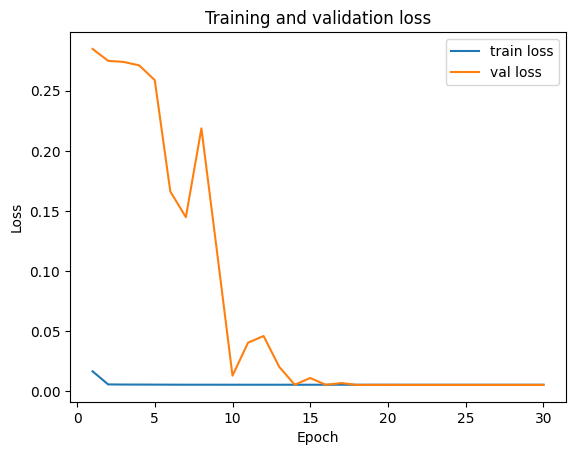

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_loss_list, label="train loss")
plt.plot(np.arange(1, Config.epochs + 1), val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

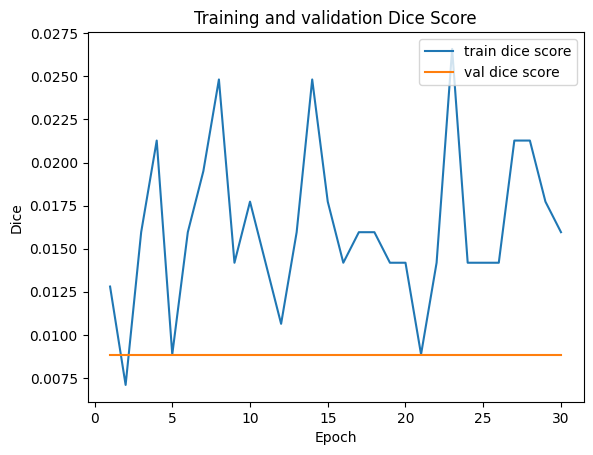

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_dice_coef, label="train dice score")
plt.plot(np.arange(1, Config.epochs + 1), val_dice_coef, label="val dice score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.title("Training and validation Dice Score")
plt.show()

0.22826713


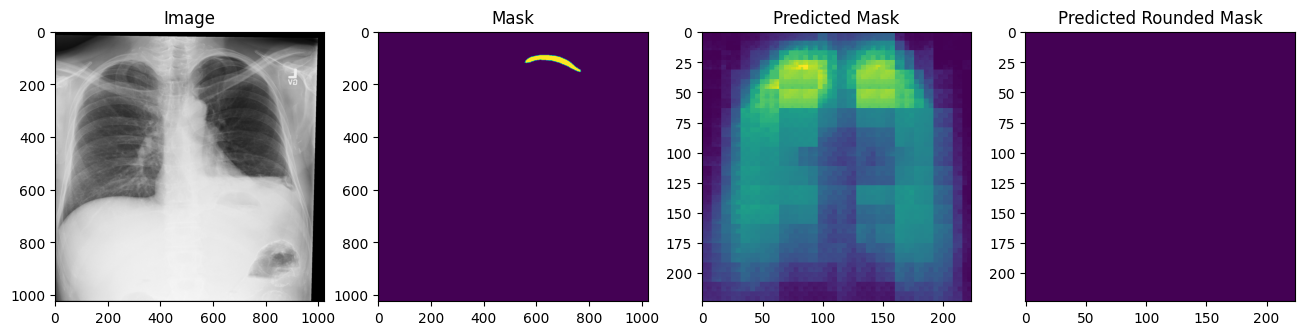

0.22821355


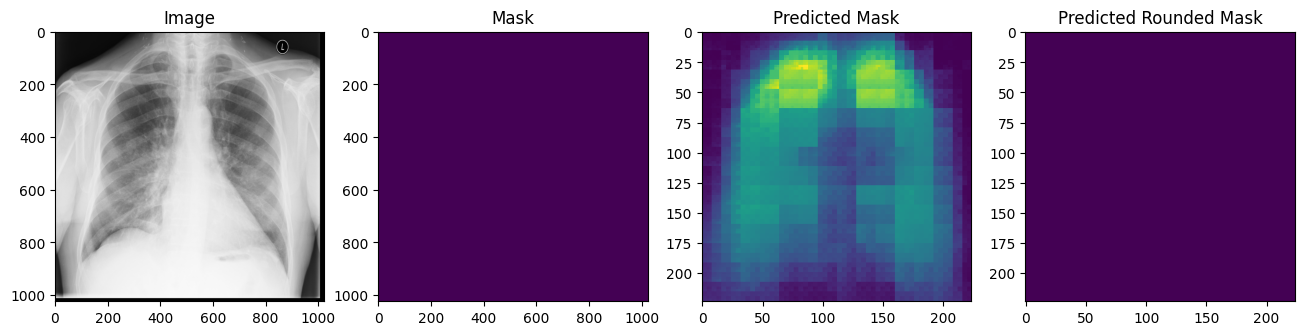

0.22580203


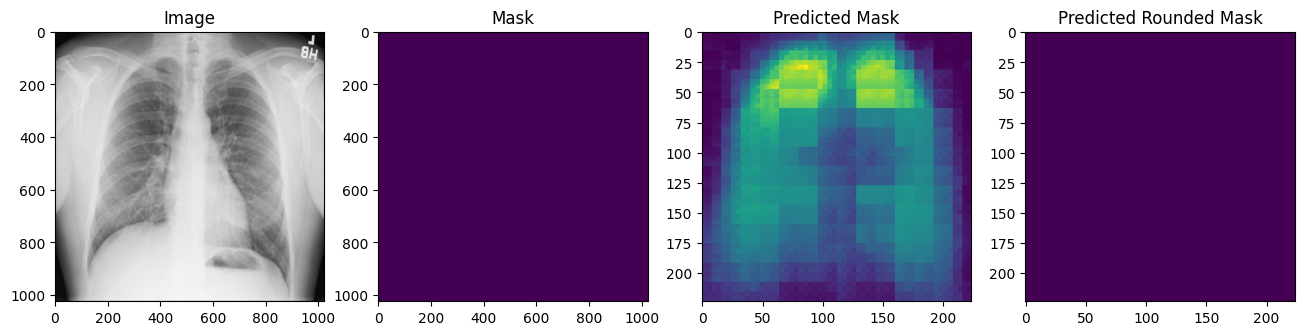

0.23945394


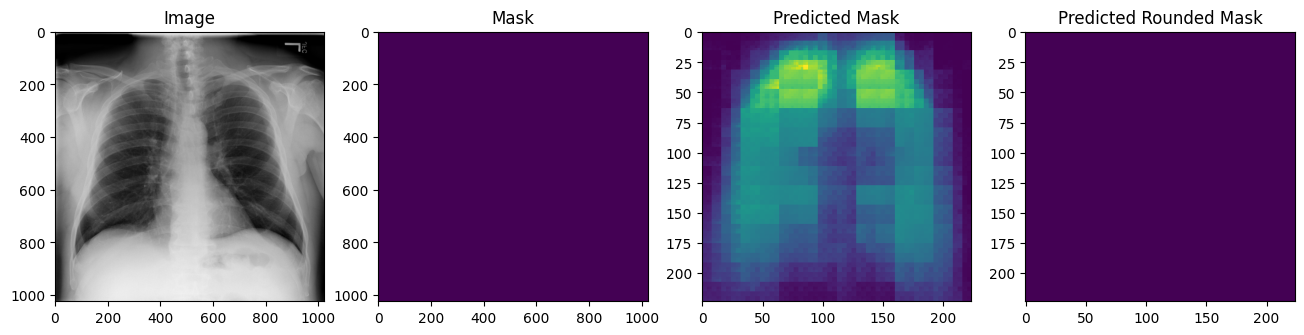

In [ ]:
plot_predictions(model, 59, transform)
plot_predictions(model, 0, transform)
plot_predictions(model, 26, transform)
plot_predictions(model, 3, transform)

0.22821355


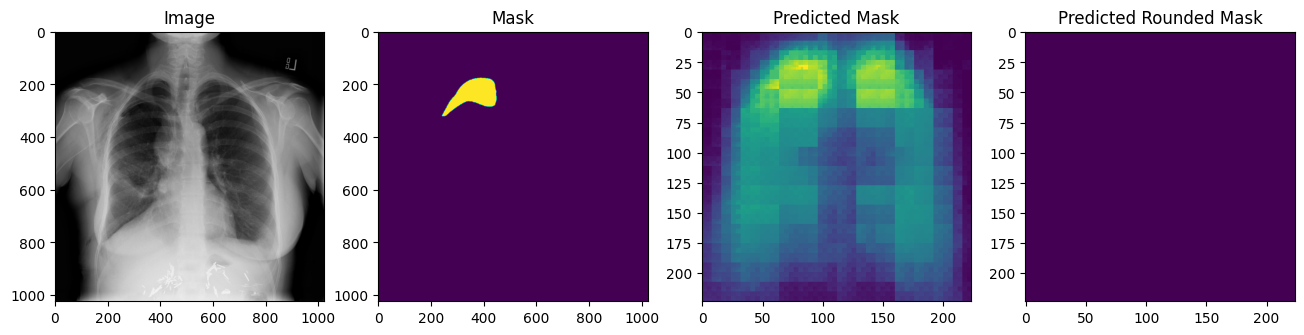

0.22821355


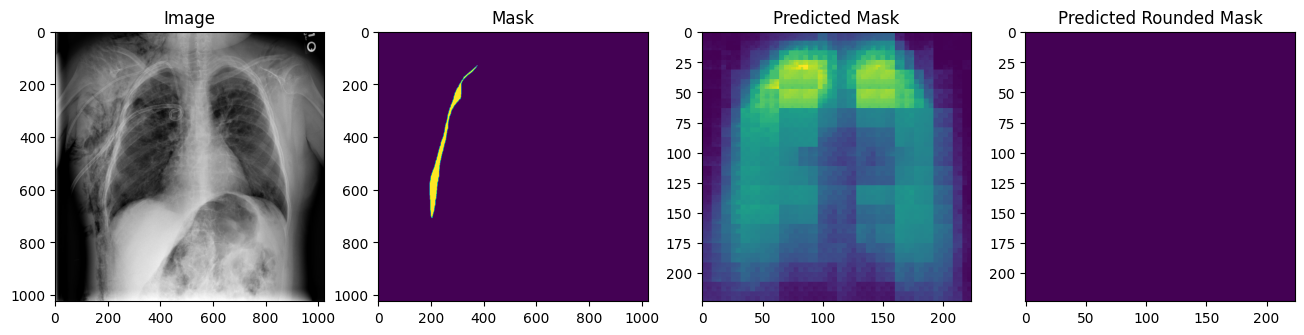

0.22825071


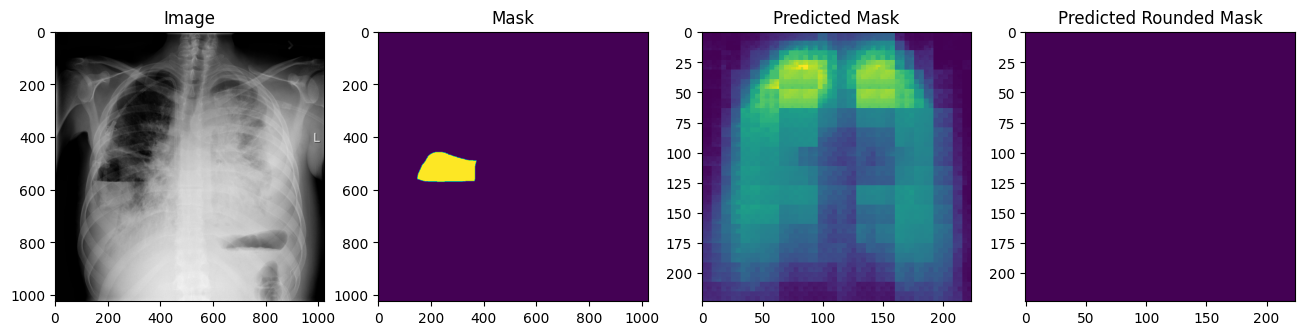

0.22580707


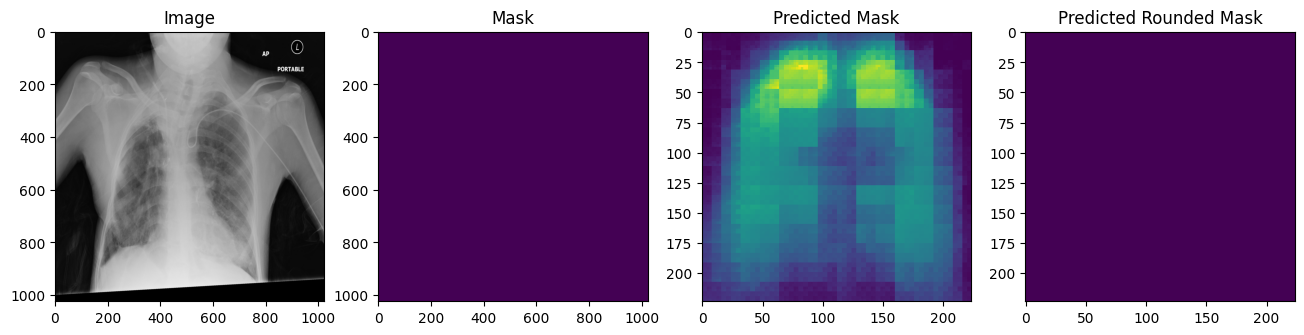

In [ ]:
plot_predictions(model, 7, transform)
plot_predictions(model, 31, transform)
plot_predictions(model, 28, transform)
plot_predictions(model, 1, transform)

0.22580203


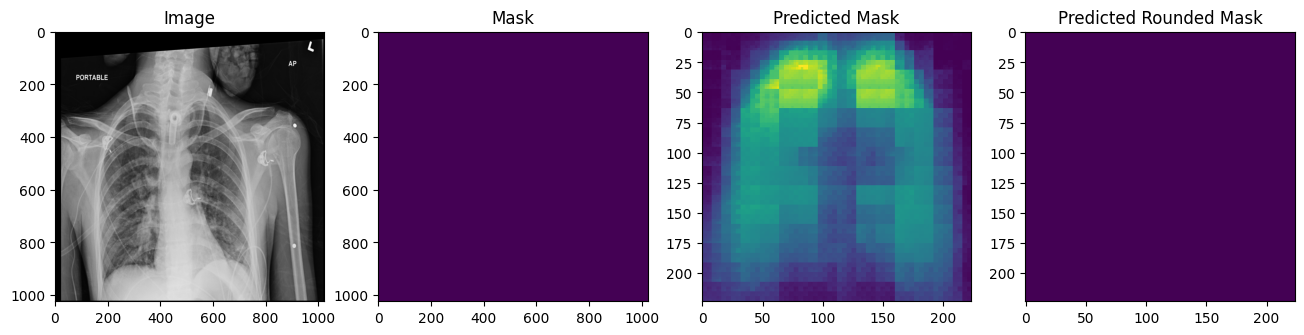

0.23945394


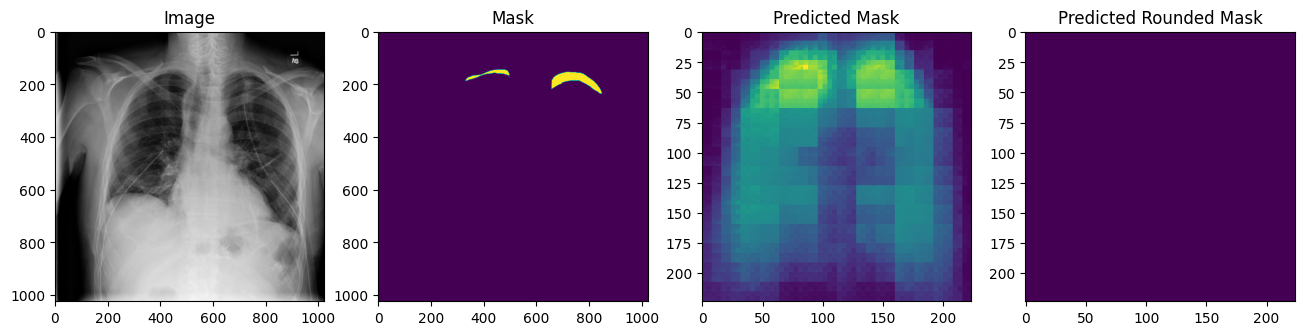

0.22826204


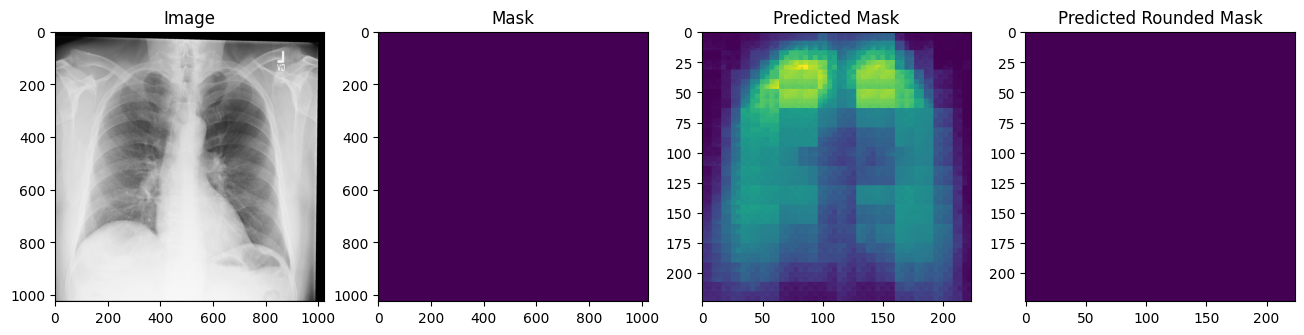

0.23946622


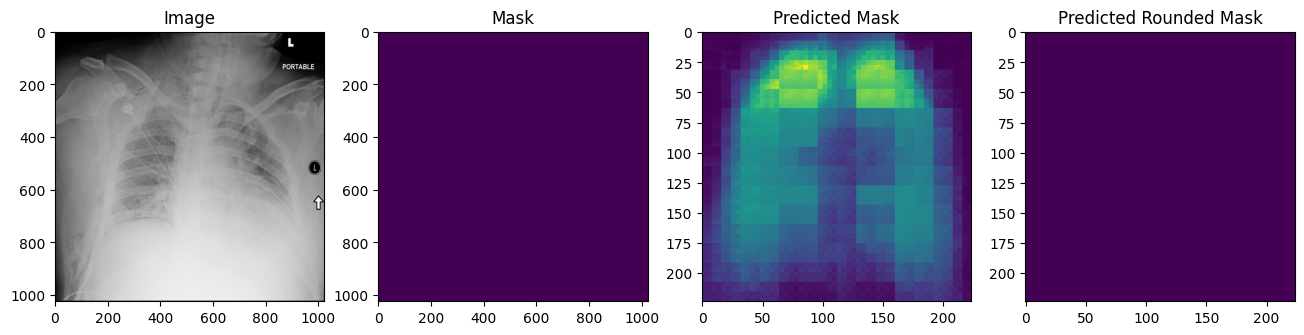

In [ ]:
plot_predictions(model, 15, transform)
plot_predictions(model, 19, transform)
plot_predictions(model, 25, transform)
plot_predictions(model, 73, transform)